<a href="https://colab.research.google.com/github/mrMichalR/Transfer_learning/blob/main/artificial_lunar_landscape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
!pip install opendatasets
!pip install torch torchvision
# !pip install segmentation_models
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null

# Training an image classifier
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [35]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import tensorflow as tf
import keras
import os
from os import listdir
from PIL import Image as PImage
# os.environ["SM_FRAMEWORK"] = "tf.keras"
# from tensorflow import keras
# import segmentation_models as sm
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# from torch import nn
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

import pandas as pd
from torchvision.io import read_image
import cv2

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
# #!/usr/bin/python
# import os
# from os import listdir
# from PIL import Image as PImage

# def loadImages(path):
#     # return array of images

#     imagesList = listdir(path)
#     loadedImages = []
#     for image in imagesList:
#         img = PImage.open(path + image)
#         loadedImages.append(img)

#     return loadedImages
# ROOT = '/content/drive/MyDrive/week4/images'
# RENDER_IMAGE_DIR_PATH = os.path.join(ROOT, 'render/')
# GROUND_MASK_DIR_PATH = os.path.join(ROOT, 'clean/')

# # your images in an array
# render = loadImages(RENDER_IMAGE_DIR_PATH)
# mask = loadImages(RENDER_IMAGE_DIR_PATH)

# render[0:5]

# for img in render[0:5]:
#     # you can show every image
#     img.show()

In [ ]:
/content/artificial-lunar-rocky-landscape-dataset/images

In [36]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/romainpessia/artificial-lunar-rocky-landscape-dataset/download?datasetVersionNumber=6'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: micharobak
Your Kaggle Key: ··········


100%|██████████| 5.02G/5.02G [01:00<00:00, 89.2MB/s]


https://www.kaggle.com/code/balraj98/unet-for-building-segmentation-pytorch

https://www.kaggle.com/code/shubhamptrivedi/transferlearning-u-net-for-segmenting-lunar-image#notebook-container

https://www.kaggle.com/code/carloalbertobarbano/vgg16-transfer-learning-pytorch

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html



https://colab.research.google.com/github/qubvel/segmentation_models.pytorch/blob/master/examples/binary_segmentation_intro.ipynb#scrollTo=O4nq08ILaYhn

https://colab.research.google.com/github/catalyst-team/catalyst/blob/v21.02rc0/examples/notebooks/segmentation-tutorial.ipynb#scrollTo=g4Vqm9FzY254


# Necessary functions

In [39]:
ROOT = '/content/artificial-lunar-rocky-landscape-dataset/images'
CLEAN = '/content/artificial-lunar-rocky-landscape-dataset/images/clean'
GROUND = '/content/artificial-lunar-rocky-landscape-dataset/images/ground'
RENDER = '/content/artificial-lunar-rocky-landscape-dataset/images/render'

BATCH_SIZE = 4
H = 480
W = 480

In [40]:
'''This function is used to return the list of path for images and masks in
sorted order from the given directory respectively.'''
# function to return list of image paths and mask paths
def process_data(IMG_DIR, MASK_DIR):
    images = [os.path.join(IMG_DIR, x) for x in sorted(os.listdir(IMG_DIR))]
    masks = [os.path.join(MASK_DIR, x) for x in sorted(os.listdir(MASK_DIR))]

    return images, masks

'''This function is used to return splitted list of images and corresponding
mask paths in train and test by providing test size.'''
# function to load data and train test split
def load_data(IMG_DIR, MASK_DIR):
    X, y = process_data(IMG_DIR, MASK_DIR)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

'''This function is used to read images. It takes image path as input.
After reading image it is resized by width and height provide above(480 x 480).
Next normalization is done by dividing each values with 255. And the result is returned.'''
# function to read image
def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

'''This function is used to read masks.'''
# function to read mask
def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x.astype(np.int32)
    return x

# '''This function is used to generate tensorflow data pipeline.
# The tensorflow data pipeline is mapped to function ‘preprocess’ .'''
# # function for tensorflow dataset pipeline
# def tf_dataset(x, y, batch=8):
#     dataset = tf.data.Dataset.from_tensor_slices((x, y))
#     dataset = dataset.shuffle(buffer_size=5000)
#     dataset = dataset.map(preprocess)
#     dataset = dataset.batch(batch)
#     dataset = dataset.repeat()
#     dataset = dataset.prefetch(2)
#     return dataset

'''This function takes image and mask path.
It reads the image and mask as provided by paths.
Mask is one hot encoded for multi class segmentation (here 4 class).'''
# function to read image and mask amd create one hot encoding for mask
def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()

        image = read_image(x)
        mask = read_mask(y)

        return image, mask

    image, mask = tf.numpy_function(f, [x, y], [tf.float32, tf.int32])
    mask = tf.one_hot(mask, 4, dtype=tf.int32)
    image.set_shape([H, W, 3])
    mask.set_shape([H, W, 4])

    return image, mask

In [32]:
# count = 0
# # Iterate directory
# for path in os.listdir(RENDER):
#     # check if current path is a file
#     if os.path.isfile(os.path.join(RENDER, path)):
#         count += 1
# print('File count:', count)

# count2 = 0
# # Iterate directory
# for path in os.listdir(CLEAN):
#     # check if current path is a file
#     if os.path.isfile(os.path.join(CLEAN, path)):
#         count2 += 1
# print('File count:', count2)

File count: 9776
File count: 9766


In [41]:
X_train, X_test, y_train, y_test = load_data(RENDER, CLEAN)
print(f"Dataset:\n Train: {len(X_train)} \n Test: {len(X_test)}")

Dataset:
 Train: 7812 
 Test: 1954


# Load data

# Data augmentation

In [42]:
# the training transforms
train_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.RandomRotation(degrees=(30, 70)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# the validation transforms
valid_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [43]:
# training dataset
train_dataset = torchvision.datasets.ImageFolder(root=ROOT, transform=train_transform)
train_class_names = train_dataset.classes
print(train_class_names)
# validation dataset
valid_dataset = torchvision.datasets.ImageFolder(root=ROOT, transform=valid_transform)
val_class_names = valid_dataset.classes
print(val_class_names)

['clean', 'ground', 'render']
['clean', 'ground', 'render']


In [44]:
n_cpu = os.cpu_count()
# training data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=n_cpu,
    collate_fn=None,
    pin_memory=False,
)

# validation data loaders
valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=n_cpu,
    collate_fn=None,
    pin_memory=False,

)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

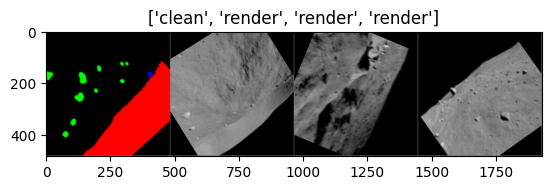

In [45]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[train_class_names[x] for x in classes])

https://medium.com/jun94-devpblog/pytorch-1-transform-imagefolder-dataloader-7f75f0a460c0

In [ ]:
# root = os.path.join(os.getcwd(),'drive/MyDrive/week4/images')
# def get_data_loader(data_dir= root, batch_size=2, train = True):
#     """
#     Define the way we compose the batch dataset including the augmentation for increasing the number of data
#     and return the augmented batch-dataset
#     :param data_dir: root directory where the either train or test dataset is
#     :param batch_size: size of the batch
#     :param train: true if current phase is training, else false
#     :return: augmented batch dataset
#     """

#     # define how we augment the data for composing the batch-dataset in train and test step
#     transform = {
#         'train': transforms.Compose([
#             transforms.Resize([224,224]), # Resizing the image as the VGG only take 224 x 244 as input size
#             transforms.RandomHorizontalFlip(), # Flip the data horizontally
#             #TODO if it is needed, add the random crop
#             transforms.ToTensor(),
#             transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
#         ]),
#         'test': transforms.Compose([
#             transforms.Resize([224,224]),
#             transforms.RandomHorizontalFlip(),
#             transforms.ToTensor(),
#             transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
#         ])
#     }

#     # ImageFloder with root directory and defined transformation methods for batch as well as data augmentation
#     data = torchvision.datasets.ImageFolder(root=data_dir, transform=transform['train'] if train else 'test')
#     data_loader = torch.utils.data.DataLoader(dataset=data, batch_size=batch_size, shuffle=True, num_workers=4)

#     return data_loader


# # The way to get one batch from the data_loader
# if __name__ == "__main__":
#     torch.multiprocessing.freeze_support()
#     data_loader = get_data_loader()

#     for i in range(10):
#         batch_x, batch_y = next(iter(data_loader))
#         print(np.shape(batch_x), batch_y)

torch.Size([2, 3, 224, 224]) tensor([2, 2])


ValueError: ignored

# Transfer learning

https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/

In [ ]:
model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=4,                      # model output channels (number of classes in your dataset)
)

preprocess_input = get_preprocessing_fn('resnet18', pretrained='imagenet')

# model = smp.FPN('resnet34', in_channels=1)
# mask = model(torch.ones([1, 1, 64, 64]))

In [ ]:
# In the default assignment notebook unet architecture was implemented using the sequential API. But that was not very efficient and got very un satisfying results. Thus here i have implemented the Transfer learning technique using VGG-16 to build the unet architecture from the pre-trained vgg model.

#### Step 1: Creating a base model
IMG_SHAPE = (480, 480, 3)

# include_top specify that we don't want to use the top layer (classifier)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

#### Step 2: Freezing the base

# It is important to freeze the convolutional base before you compile and train the model.
# Freezing prevents the weights in a given layer from being updated during training
# VGG16 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

#### Step 3: Adding the head

# inputs
inputs = tf.keras.Input(shape=(480, 480, 3))

# base with pretrained model
x = base_model(inputs, training=False)

# head layers
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(2)(x)

# model
model = tf.keras.Model(inputs, outputs)

# Let's take a look at the final model architecture
model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 480, 480, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 480, 480, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 480, 480, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 240, 240, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 240, 240, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 240, 240, 128)     147584    
                                                              

In [ ]:
BACKBONE = 'vgg16'
input_shape = (H, W, 3)
n_classes = 4
activation = 'softmax'

# using segmentation_models to create U-net with vgg16 as a backbone
# and pretrained imagenet weights

# segmentation_model basically will create a mirror image of our backbone as expansion path and add to the contraction path
model = smp.Unet(backbone_name = BACKBONE,
                input_shape = input_shape,
                classes = n_classes,
                activation = activation,
                encoder_weights = 'imagenet')
model.summary()

# 1. Load and normalize CIFAR10

In [ ]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

The output of torchvision datasets are PILImage images of range [0, 1].

**We transform them to Tensors of normalized range [-1, 1].**

*) PIL - Python Image Librabry

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5) #torchvision.transforms.Normalize(mean, std, inplace=False) ; mean=0,5 and std=0,5 result in pixel value range 0-1 (0,5 +/-0,5)
    ])

batch_size = 2 # number of images taken at one run

trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=True,
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=5)

testset = torchvision.datasets.CIFAR10(root='./data',
                                       train=False,
                                       download=True,
                                       transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=5)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


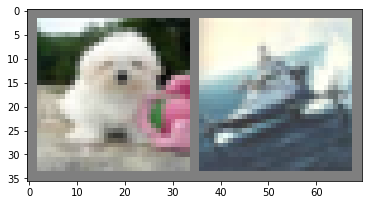

dog   ship 


In [ ]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# 2. Define a Convolutional Neural Network

Example of NN structure

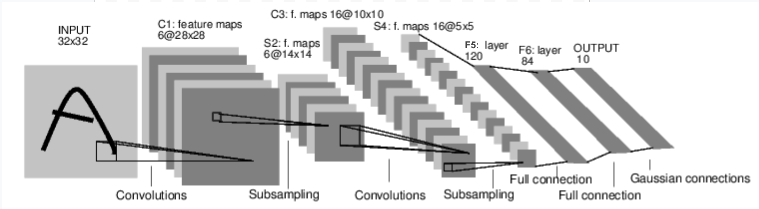

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # 3 input image channel (RGB) size (32x32), 6 output channels, 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(3, 6, 5) # Conv2d(in_channels= 3 (here RGB), out_channels=6, kernel_size=5, ...)
        self.pool = nn.MaxPool2d(2, 2) # MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # Linear(in_features, out_features, bias=True, device=None, dtype=None)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

# 3. Define a Loss function and optimizer


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 4. Train the network

In [ ]:
epochs=2

for epoch in tqdm(range(int(epochs)),desc='Training Epochs'): # loop over the dataset multiple times
# for epoch in range(int(epochs)): # loop over the dataset multiple times
    running_loss = 0.0
    # for i, data in tqdm(enumerate(trainloader, 0),total=i, desc='Training Epochs'):
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('\nFinished Training')

Training Epochs:   0%|          | 0/2 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f45e6a9eca0>Exception ignored in: Exception ignored in: Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f45e6a9eca0><function _MultiProcessingDataLoaderIter.__del__ at 0x7f45e6a9eca0>Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f45e6a9eca0>

  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
Traceback (most recent call last):
Traceback (most recent call last):
      File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__

  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    Traceback (most recent call last):
self._shutdown_workers()    Exception ignored in: self._shutdown_workers()  File "/usr/local/lib/python3.9/dist-packages/torch/utils

[1,  2000] loss: 1.304


Training Epochs:   0%|          | 0/2 [00:16<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

# 5. Test the network on the test data

We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

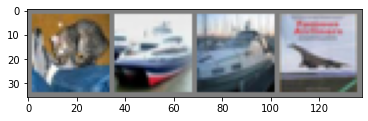

GroundTruth:  cat   ship  ship  plane


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

For education, load back in our saved model (note: saving and re-loading the model wasn’t necessary)

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   plane ship  plane


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 52 %


Check accuracy for each classes correct prediction

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 57.2 %
Accuracy for class: car   is 65.8 %
Accuracy for class: bird  is 58.7 %
Accuracy for class: cat   is 30.6 %
Accuracy for class: deer  is 46.6 %
Accuracy for class: dog   is 53.2 %
Accuracy for class: frog  is 55.2 %
Accuracy for class: horse is 47.7 %
Accuracy for class: ship  is 69.2 %
Accuracy for class: truck is 39.6 %


# Training on GPU

Just like how you transfer a Tensor onto the GPU, you transfer the neural net onto the GPU.

Let’s first define our device as the first visible cuda device if we have CUDA available:

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


The rest of this section assumes that device is a CUDA device.

Then these methods will recursively go over all modules and convert their parameters and buffers to CUDA tensors:

In [ ]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
# inputs, labels = data[0].to(device), data[1].to(device)
epochs=2

for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Training Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

[1,  2000] loss: 1.234
[1,  4000] loss: 1.225
[1,  6000] loss: 1.244
[1,  8000] loss: 1.225
[1, 10000] loss: 1.240
[1, 12000] loss: 1.240


Training Epochs:  50%|█████     | 1/2 [01:09<01:09, 70.00s/it]

[2,  2000] loss: 1.236
[2,  4000] loss: 1.237
[2,  6000] loss: 1.216
[2,  8000] loss: 1.250
[2, 10000] loss: 1.235
[2, 12000] loss: 1.230


Training Epochs: 100%|██████████| 2/2 [02:13<00:00, 66.58s/it]

Finished Training
